In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Dataset import and preparations
**The same steps as the model_training.ipynb file is repeated here to import and prepare the dataset**

-Import the dataset.csv file created by the dataset_builder.py file

-Add column headers to the dataset and drop any unwanted null values from the dataset

-The number of samples for each mode of transportation is also shown below

In [2]:
data = "TMD_Datasets/dataset.csv"
dataset = pd.read_csv(data, header=None)

col_names = ['Distance','Speed', 'Acceleration', 'Avg Speed', 'STD speed', 'Max Speed', '75% percentile speed' , '50% percentile speed','Avg Acc', 'STD Acc' ,'Mode']
dataset.columns = col_names

dataset.dropna(inplace=True)

features = ['Distance','Speed', 'Acceleration', 'Avg Speed', 'STD speed', 'Max Speed', '75% percentile speed' , '50% percentile speed','Avg Acc', 'STD Acc']
classes = ['Bike','Bus', 'Subway','Car', 'Walk']

dataset['Mode'].value_counts()

Subway    22281
Car        5949
Walk       1965
Bus        1859
Bike       1307
Name: Mode, dtype: int64

## Training the initial model
-Dataset is divided into input and output variables represent by x and y respectively

-Dataset is then split into a training and testing subset with 70/30 split 

-Dataset is then trained using the "Decision Tree Classifier" from the Scikit-Learn library, however no hyper-parameters are specified in the parameters of the decision tree classifier when the cell is executed. Random_state is the only parameter which is passed and specified and that is only done to have consistent results every time the model runs again. The absence of this parameter causes variation in the calculation results every time the code is rerun

-The accuracy of the model with no hyper-parameter specification is shown in the output of the cell below

In [3]:
x = dataset.drop(['Mode'], axis=1)
y = dataset['Mode']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 1234)

clf = DecisionTreeClassifier(random_state = 1234)

clf.fit(x_train, y_train)

y_pred_test = clf.predict(x_test)
y_pred_train = clf.predict(x_train)

print('Model training set score: {:.4f}'.format(clf.score(x_train, y_train)))
print('Model testing set score: {:.4f}'.format(clf.score(x_test, y_test)))

Model training set score: 1.0000
Model testing set score: 0.9246


## Initial decision tree visualization and statistics
Based on the accuracies shown above and the visual plot of the decision tree as well as the results from the confusion matrix and the classification report shown below, it is clear that the model here is overfitting. These suggest that the hyperparameter of the decision tree need to be tuned and modified to overcome this overfitting issue

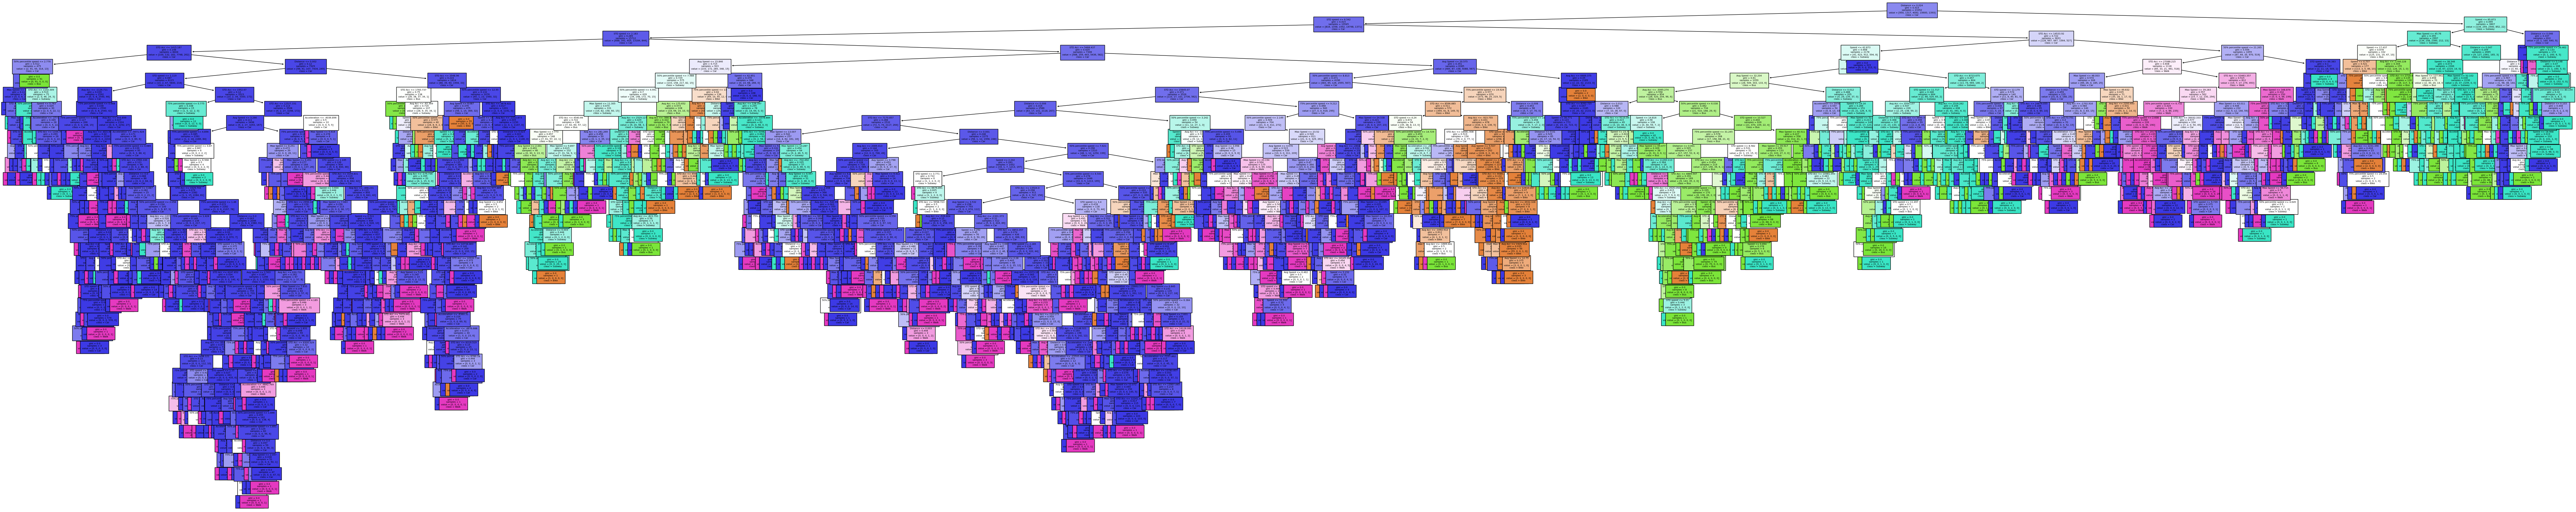

In [4]:
# Initial decision tree diagram
plt.figure(figsize=(100,20))
tree.plot_tree(clf,fontsize=5, filled=True, feature_names=features,class_names=classes) 
plt.savefig('model_optimization_initial_tree', dpi=300)

In [5]:
# Helper Function for the confusion Matrix - will be used mutiple used times throughout this file
def plot_confusionmatrix(y_pred_train,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_pred_train,y_train, labels=classes)
    sns.heatmap(cf,annot=True,yticklabels=classes,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()

Training score 1.0
Testing score 0.92456788889999
Train Confusion matrix


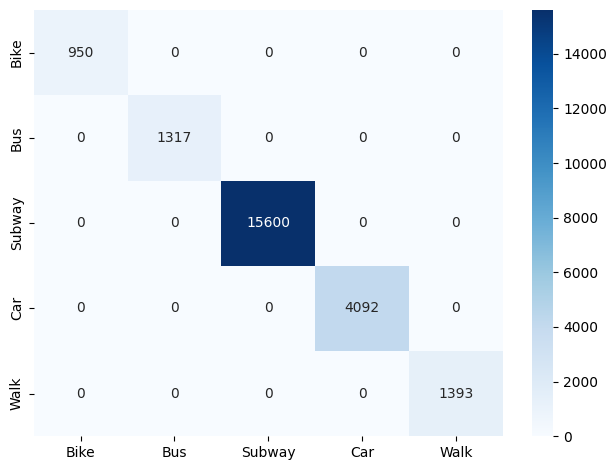

Test Confusion matrix


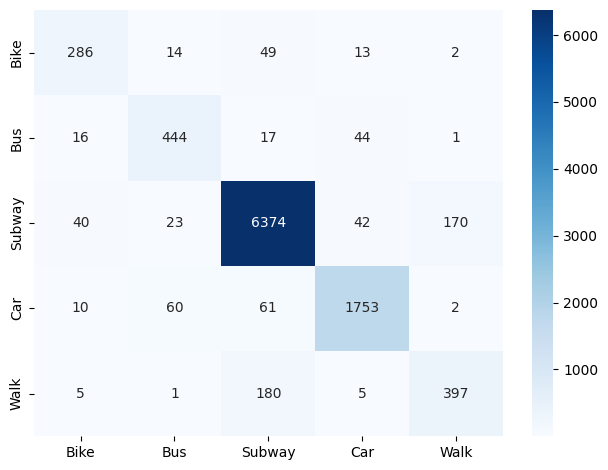

In [6]:
print(f'Training score {accuracy_score(y_pred_train,y_train)}')
print(f'Testing score {accuracy_score(y_pred_test,y_test)}')
plot_confusionmatrix(y_pred_train,y_train,dom='Train')
plot_confusionmatrix(y_pred_test,y_test,dom='Test')

In [7]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

        Bike       0.79      0.80      0.79       357
         Bus       0.85      0.82      0.83       542
         Car       0.93      0.94      0.94      1857
      Subway       0.96      0.95      0.96      6681
        Walk       0.68      0.69      0.68       572

    accuracy                           0.92     10009
   macro avg       0.84      0.84      0.84     10009
weighted avg       0.93      0.92      0.92     10009



## Finding the optimal hyper-parameter values
the GridSearchCV library is used to test how changing the hyper-parameter values affects the accuracy of the model. A graph is also drawn for each of the hyper-parameters tested by the GridSearchCV library showing what values for these parameters yield the most accurate model

In [8]:
# Process can take a couple of minutes to execute
params = {'criterion': ['gini', 'entropy','log_loss'], 'splitter': ['best','random'], 'max_depth': [10,15,18,20,22,25,30,40],'min_samples_split': [2,5,10,15],'min_samples_leaf': [1,5,10,20], 'random_state': [1234] }

clf = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params, return_train_score=True)
gcv.fit(x_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [10, 15, 18, 20, 22, 25, 30, 40],
                         'min_samples_leaf': [1, 5, 10, 20],
                         'min_samples_split': [2, 5, 10, 15],
                         'random_state': [1234],
                         'splitter': ['best', 'random']},
             return_train_score=True)

In [9]:
gcv.best_params_

{'criterion': 'entropy',
 'max_depth': 22,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 1234,
 'splitter': 'best'}

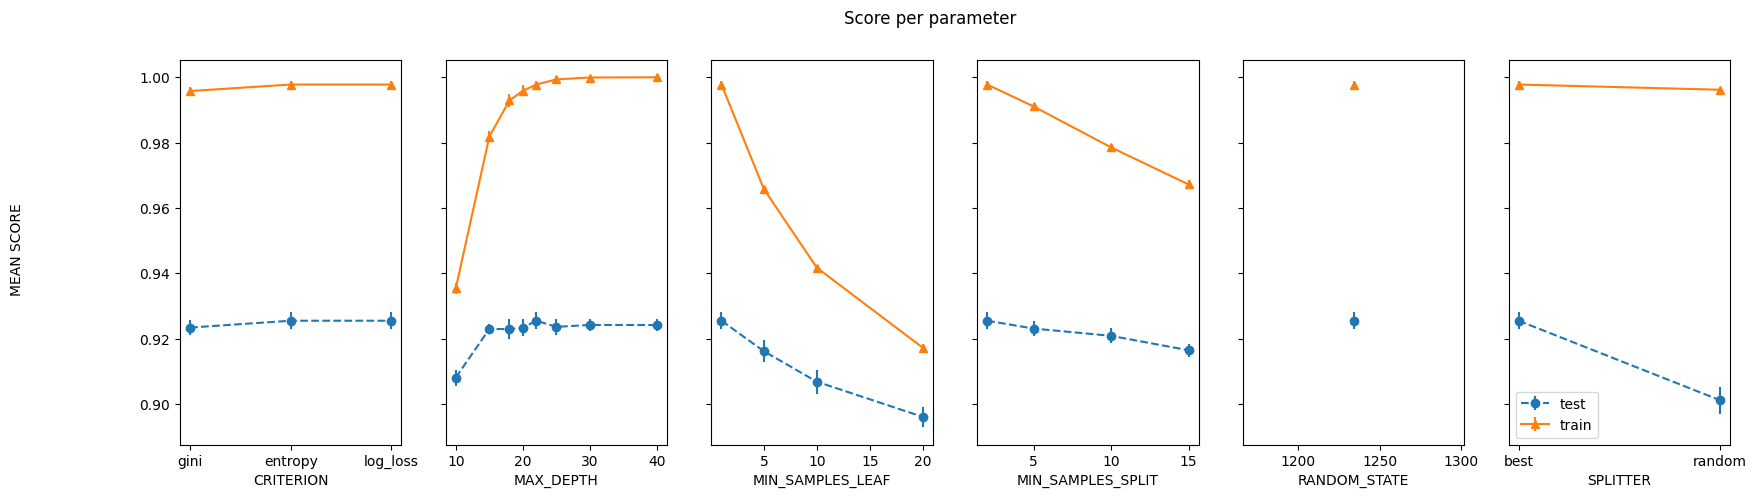

In [10]:
# Results from grid search
results = gcv.cv_results_
means_test = results['mean_test_score']
stds_test = results['std_test_score']
means_train = results['mean_train_score']
stds_train = results['std_train_score']

# Getting indexes of values per hyper-parameter
masks=[]
masks_names= list(gcv.best_params_.keys())
for p_k, p_v in gcv.best_params_.items():
    masks.append(list(results['param_'+p_k].data==p_v))

params=gcv.param_grid

# Ploting results
fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
fig.suptitle('Score per parameter')
fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
pram_preformace_in_best = {}
for i, p in enumerate(masks_names):
    m = np.stack(masks[:i] + masks[i+1:])
    pram_preformace_in_best
    best_parms_mask = m.all(axis=0)
    best_index = np.where(best_parms_mask)[0]
    x = np.array(params[p])
    y_1 = np.array(means_test[best_index])
    e_1 = np.array(stds_test[best_index])
    y_2 = np.array(means_train[best_index])
    e_2 = np.array(stds_train[best_index])
    ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
    ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
    ax[i].set_xlabel(p.upper())

plt.legend()
plt.show()

In [11]:
model = gcv.best_estimator_
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

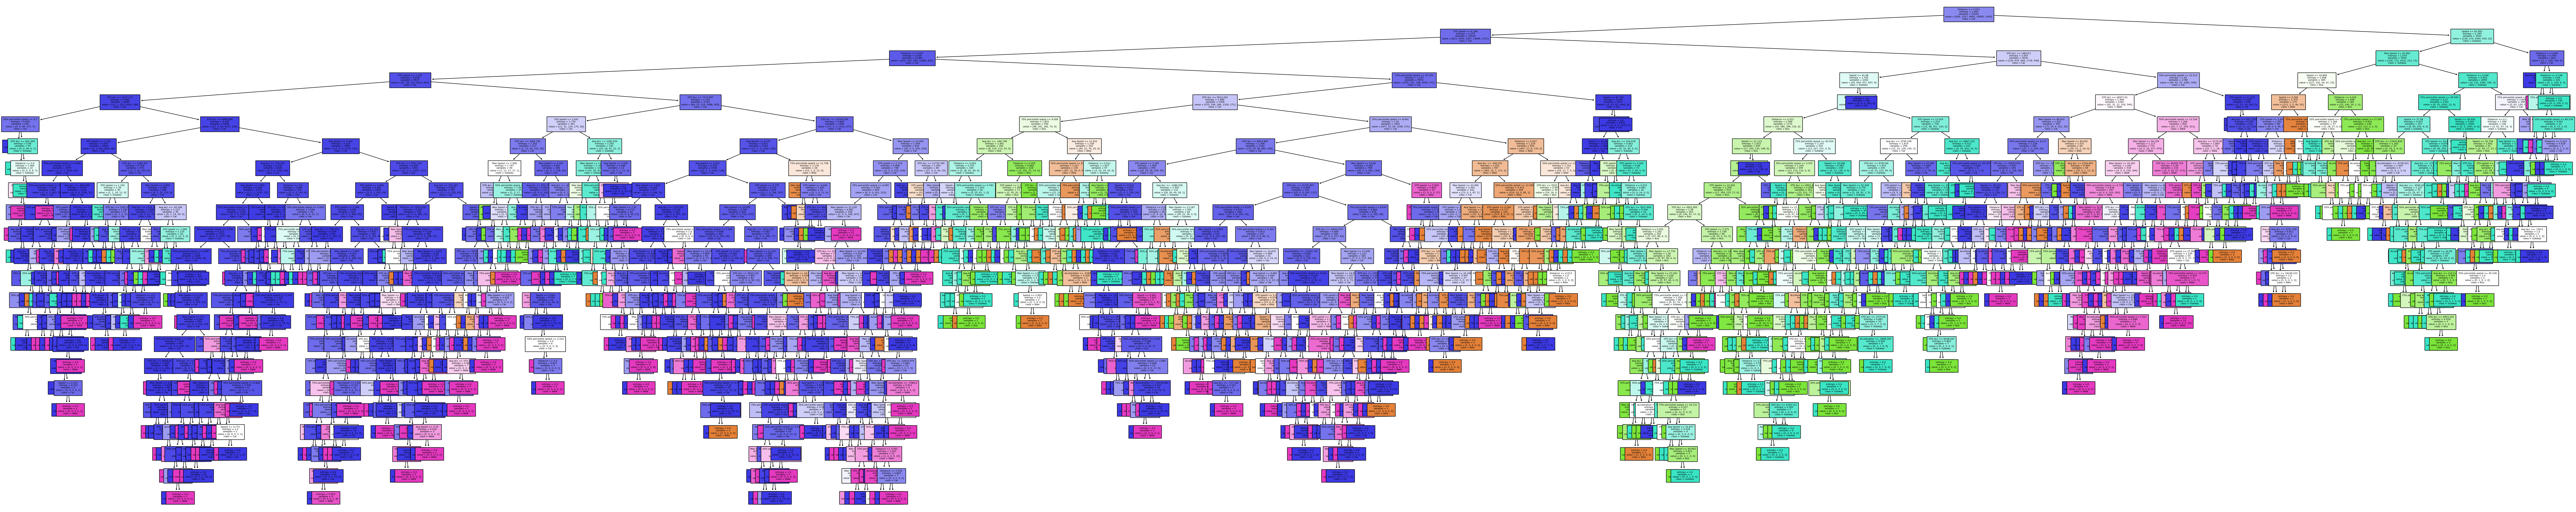

In [12]:
# Tuned decision tree diagram
plt.figure(figsize=(100,20))
tree.plot_tree(model,fontsize=5, filled=True, feature_names=features,class_names=classes) 
plt.savefig('model_optimization_tuned_tree', dpi=300)

## Getting slight improvements
The cell below shows the accuracy and the confusion matrix for the model. A slight improvement is seen in the testing accuracy with the new hyper-parameter values but as evident by the ratio of the testing accuracy to the training accuracy the model is still overfitting and further adjustment needs to be done to create an accurate model that does not overfit

Training score 0.999314833847208
Testing score 0.9334598861025077
Train Confusion matrix


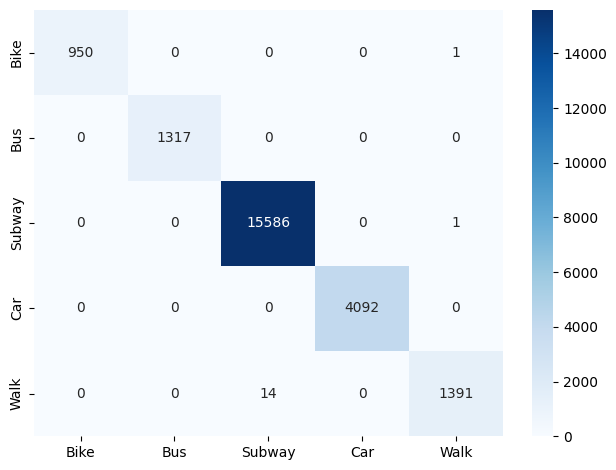

Test Confusion matrix


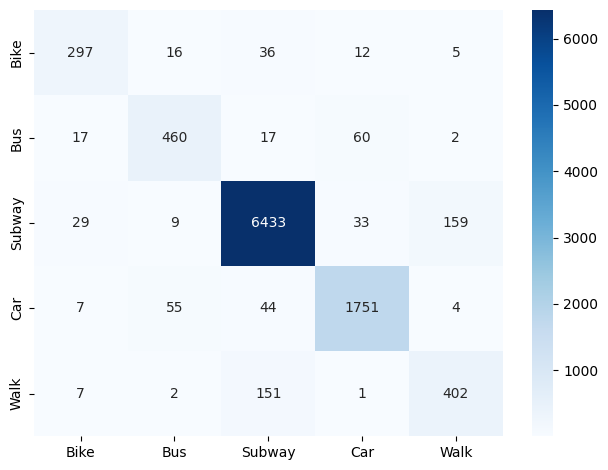

In [13]:
print(f'Training score {accuracy_score(y_train_pred,y_train)}')
print(f'Testing score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

## Post pruning of the decision tree
the "CCP_alpha" parameter is used to simplify the overall structure of the decision tree through a process which is usually referred to as post-pruning. Essentially the hyper-parameter tuning process which was done above can be thought of as the pre-pruning process, where changes to the model were made before the model was constructed. 

Post-pruning occurs after the model has been constructed and uses the cost complexity pruning technique to limit the depth and the complexity of the model so that the overfitting issue can be resolved. It is important to note that applying the ccp_alpha parameter into the decision tree will cause the accuracy of the decision tree to go down slightly but at the same time the overfitting issue is resolved. Therefore, several graphs have been constructed below to aid with the process of choosing the appropriate value for this parameter.

In [14]:
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(criterion='entropy', splitter = 'best', max_depth=22, min_samples_split=2 , min_samples_leaf=1 , min_weight_fraction_leaf=0.0 , max_features=None , random_state=1234, max_leaf_nodes=None , min_impurity_decrease=0.0 , class_weight= None , ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)

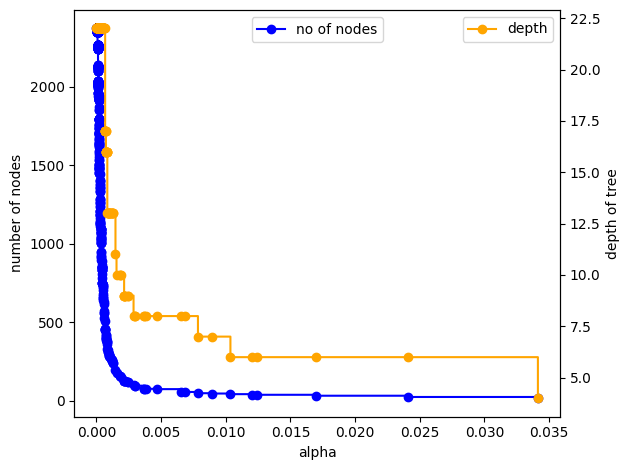

In [15]:
# Graph for the change in the number of nodes and depth of the decision tree over different ccp_alpha values
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax1 = plt.subplots()
ax1.plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post", color = "blue", label='no of nodes')
ax1.set_xlabel("alpha")
ax1.set_ylabel("number of nodes")
ax1.legend(loc = "upper center")

ax2 = ax1.twinx()

ax2.plot(ccp_alphas, depth, marker="o", drawstyle="steps-post", color = "orange", label='depth')
ax2.set_xlabel("alpha")
ax2.set_ylabel("depth of tree")
ax2.legend(loc = "best")

fig.tight_layout()

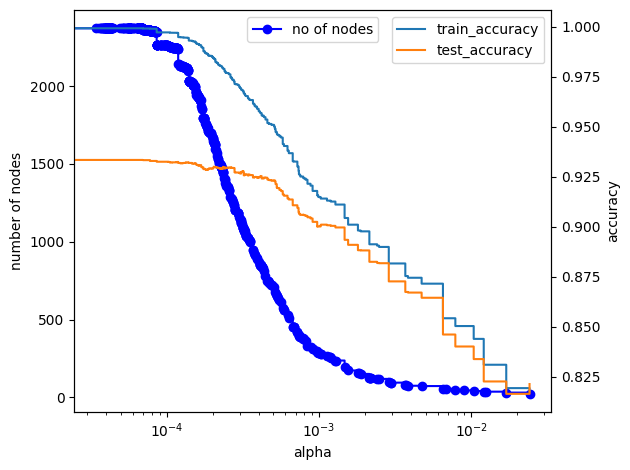

In [16]:
# Graph for the change in the number of nodes and the accuracy of the model over different ccp_alpha values
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(x_train)
    y_test_pred = c.predict(x_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

fig, ax1 = plt.subplots()
ax1.semilogx(ccp_alphas, node_counts, marker="o", drawstyle="steps-post", color = "blue", label='no of nodes')
ax1.set_xlabel("alpha")
ax1.set_ylabel("number of nodes")
ax1.legend(loc = "upper center")

ax2 = ax1.twinx()

ax2.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
ax2.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
ax2.set_xlabel("alpha")
ax2.set_ylabel("accuracy")
ax2.legend(loc = "best")

fig.tight_layout()

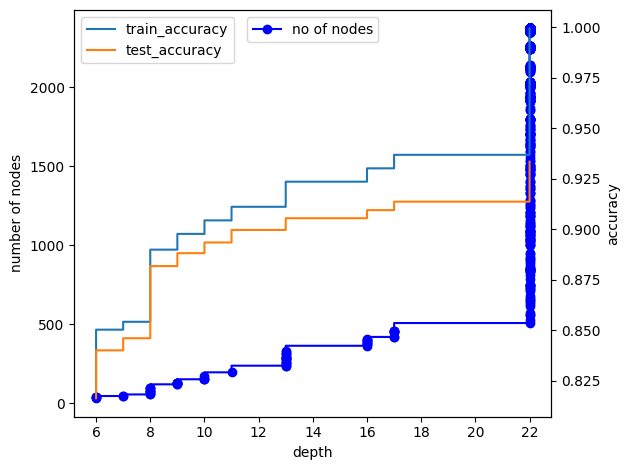

In [17]:
# Graph for the change in the number of nodes, accuracy, and depth
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(x_train)
    y_test_pred = c.predict(x_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

fig, ax1 = plt.subplots()
ax1.plot(depth, node_counts, marker="o", drawstyle="steps-post", color = "blue", label='no of nodes')
ax1.set_xlabel("depth")
ax1.set_ylabel("number of nodes")
ax1.legend(loc = "upper center")

ax2 = ax1.twinx()

ax2.plot(depth,train_acc,label='train_accuracy',drawstyle="steps-post")
ax2.plot(depth,test_acc,label='test_accuracy',drawstyle="steps-post")
ax2.set_xlabel("depth")
ax2.set_ylabel("accuracy")
ax2.legend(loc = "best")

fig.tight_layout()

## Finalizing the post pruning process
As evident especially in the second graph above, the testing set accuracy of the model starts to rapidly drop right after an alpha value of 10^(-3) or 0.001. A similar drop is also seen in the training set accuracy at approximately the halfway point between the 10^(-4) and the 10^(-3) point. Therefore using these points for reference, an alpha value of 0.00075 is ultimately chosen for the decision tree 

In [18]:
clf_new = tree.DecisionTreeClassifier(criterion='entropy', splitter = 'best', max_depth=22, min_samples_split=2 , min_samples_leaf=1 , min_weight_fraction_leaf=0.0 , max_features=None , random_state=1234, max_leaf_nodes=None , min_impurity_decrease=0.0 , class_weight= None , ccp_alpha=0.00075)
clf_new.fit(x_train,y_train)
y_train_pred = clf_new.predict(x_train)
y_test_pred = clf_new.predict(x_test)

Training score 0.9257879410757108
Testing score 0.9063842541712459
Train Confusion matrix


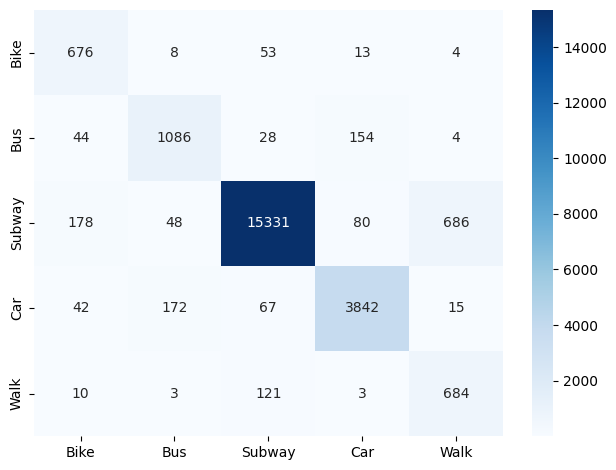

Test Confusion matrix


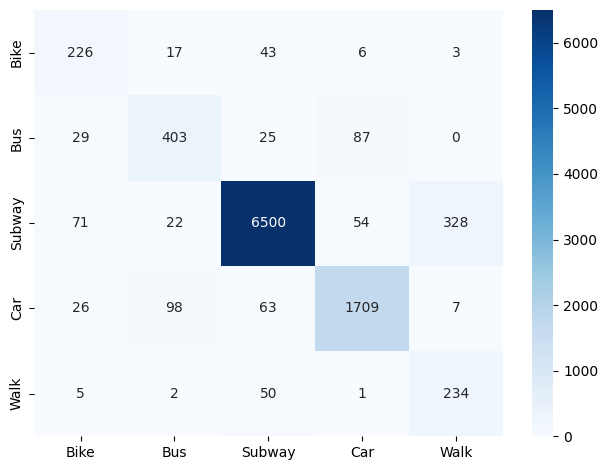

In [19]:
print(f'Training score {accuracy_score(y_train_pred,y_train)}')
print(f'Testing score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

In [20]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

        Bike       0.79      0.80      0.79       357
         Bus       0.85      0.82      0.83       542
         Car       0.93      0.94      0.94      1857
      Subway       0.96      0.95      0.96      6681
        Walk       0.68      0.69      0.68       572

    accuracy                           0.92     10009
   macro avg       0.84      0.84      0.84     10009
weighted avg       0.93      0.92      0.92     10009



## Creating the final decision tree
Finally, the optimum values for the decision tree hyper-parameters were fed into a new "clf" model. The accuracies for this new model outputted in the cells above show that the testing and training accuracies are very close to one another which indicates that no severe overfitting or underfitting is present in the model while also maintaining high accuracy (Only about 2% is just dropped from the last model prior to the post pruning process). The tree diagram below clearly shows how less complicated (shallower tree depth) this new model is compared to the model before the post pruning process. 

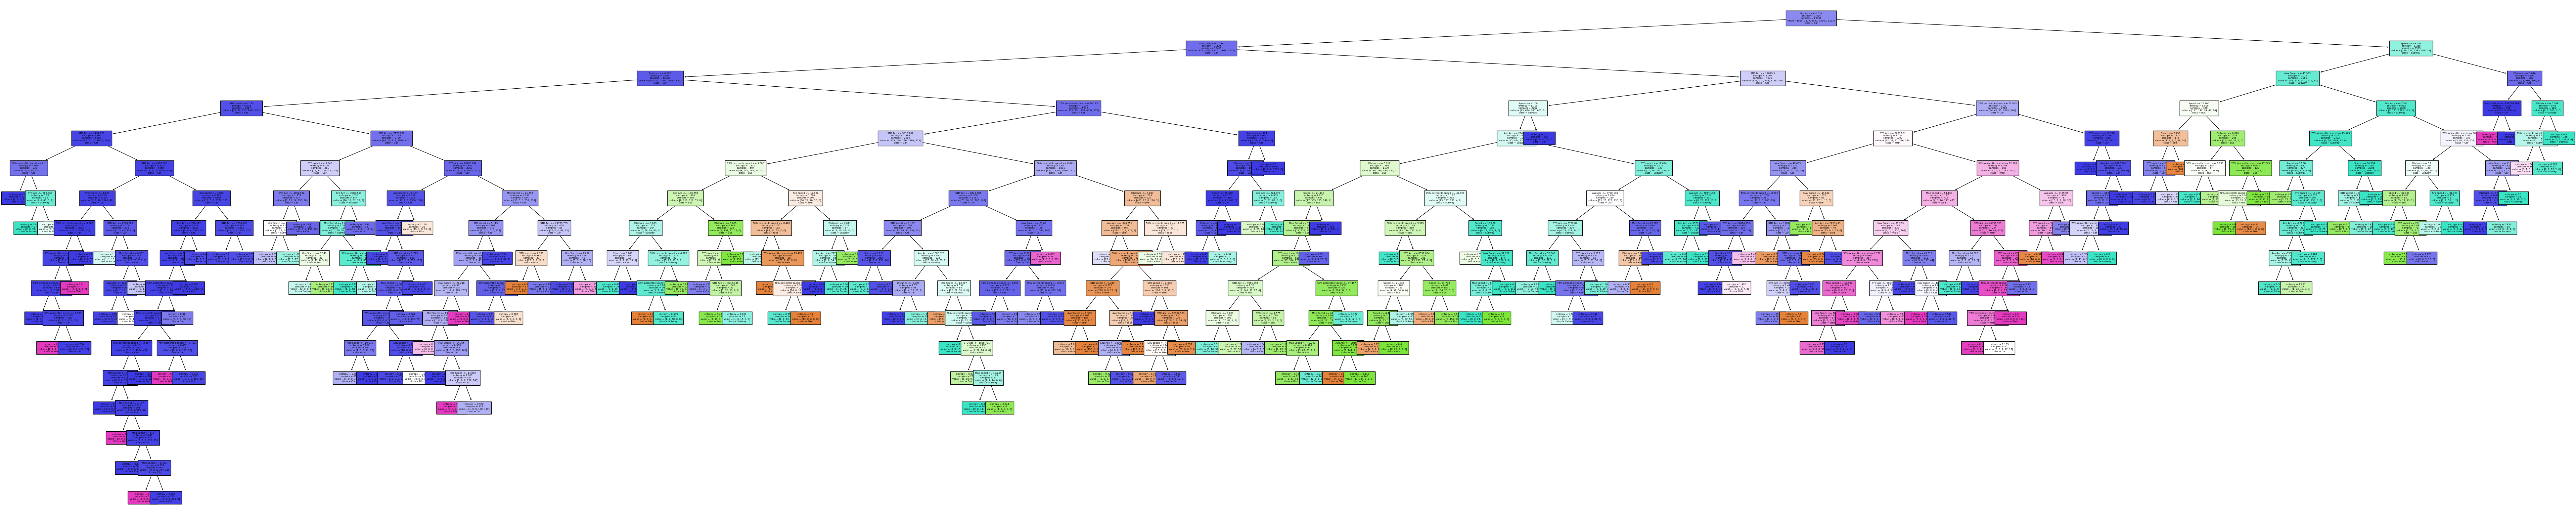

In [21]:
plt.figure(figsize=(100,20))
tree.plot_tree(clf_new,fontsize=5, filled=True, feature_names=features,class_names=classes) 
plt.savefig('model_optimization_final_tree', dpi=300)